## Classifying Newswires
In this section, we will build a network to classify Reuters newswires into 46 mutually exclusive topics. This problem is an instance of *multi-class classification*; and because each data point should be classified into only one category, the problem is more specifically an instance of *single-label, multiclass classification*. If each data point could belong to multiple categories, you'd be facing a *multilabel, multiclass classification* problem.

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
# import data and lib
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

As with the IMDB dataset, the argument num_words=10000 restricts the data to the __10000 most frequently occuring words__ found in the data

In [3]:
type(train_data)

numpy.ndarray

In [4]:
len(train_data)

8982

In [5]:
len(test_data)

2246

In [ ]:
# check the data form
train_data[10]

In [7]:
# decoding newswires back to text
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# check what exactly news 10 is
decoded_newswire = ' '.join([reverse_word_index.get(i-3, '?') for i in train_data[10]])
decoded_newswire

'? period ended december 31 shr profit 11 cts vs loss 24 cts net profit 224 271 vs loss 511 349 revs 7 258 688 vs 7 200 349 reuter 3'

In [8]:
train_labels[10]

3

### Vectorzing and ecoding the data

In [9]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

__Vectorize Labels__

One-hot encoding is a widely used format for category data, also called *categorical encoding*. In this case, one-hot encoding of the labels consists of embedding each label as an all-zero vector with a 1 in the place of the label index.

In [10]:
def to_one_hot(labels, dimension= 46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1
    return results

one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

Alternatively

In [11]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

The dimensionality of the output space is much larger

In [12]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

The last layers uses a softmax activation. You saw this pattern in the MNIST example. It means the network will output a *probability distribution* over the 46 different output classes.

In [14]:
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

### Validating approach

In [ ]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=20,
                   batch_size=512,
                   validation_data=(x_val, y_val))

### Plotting the training and validation loss

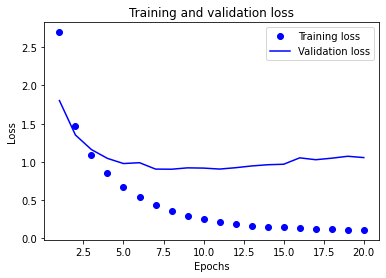

In [17]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Plotting the training and validation accuracy

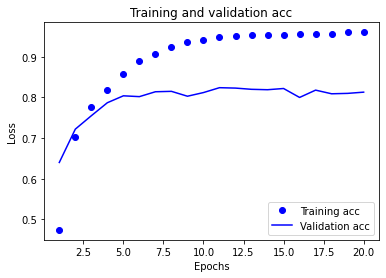

In [21]:
plt.clf()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

The network begin to overfit after nine epochs. Let's train a new network from scratch for nine epochs and then evaluate it on the test set.

In [ ]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=9,
                   batch_size=512,
                   validation_data=(x_val, y_val))

results = model.evaluate(x_test, one_hot_test_labels)

In [23]:
results

[0.9709988832473755, 0.7885128855705261]

This approach reaches an accuracy of 80%.

### Generating predictions on new data

In [24]:
predictions = model.predict(x_test)
predictions[0].shape

(46,)

In [25]:
np.sum(predictions[0])

1.0

In [28]:
np.argmax(predictions[0])

3

### Wrapping up

1. If you are trying to classify data points among N classes, your network should end with a Dense layer of size N.
2. In a single-label, multiclass classification problem, your network should end with a softmax activation so that it will output a probability distribution over the N output classes.
3. If you need to classify data into a large number of categories, you should avoid creating information bottle necks in your network due to intermediate layers that are too small